In [1]:
import random
import math
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000
simulation_years = 50

birth_rate = 0.011
death_rate = 0.23014
death_age = 80
retirement_age = 65

initial_participation_rate = 0.7
initial_aging_rate = 0.1
initial_unemployment_rate = 0.05

job_finding_rate = 0.2
job_separation_rate = 0.01

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed
    
    def update_age(self):
        self.age += 1
        
    def is_newborn(self):
        return self.age == 0
    
    def is_young(self):
        return self.age < 15
    
    def is_workforce(self):
        return 14 < self.age < retirement_age
    
    def is_senior(self):
        return self.age >= retirement_age 

    def is_unemployed(self):
        return not self.employed
    
    def is_employed(self):
        return self.employed

import random

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, labor_market):
        hire_or_fire_decision = self.price > self.vacancy_cost

        if hire_or_fire_decision:  # Hiring decision
            num_unemployed = len([p for p in labor_market.workforce if p.is_unemployed()])
            num_hired = min(num_unemployed, int(num_unemployed * labor_market.job_finding_rate))
            self.job_vacancy += num_hired
            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_employed = len([p for p in labor_market.workforce if p.is_employed()])
            num_fired = min(num_employed, int(num_employed * labor_market.job_separation_rate))
            self.job_vacancy -= num_fired
            return 0, num_fired, self.job_vacancy

    def post_price(self, price):
        self.price = price

        # Open new job vacancies based on price and vacancy cost difference
        num_new_vacancies = int((price - self.vacancy_cost) * 10)
        self.job_vacancy += num_new_vacancies
        return self.job_vacancy

shopping_propensity_retirees = 0.1
shopping_propensity_unemployed = 0.1
shopping_propensity_employed = 0.9

class GoodsMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_demand(self, consumers):
        total_demand = 0
        for consumer in consumers:
            if consumer.is_senior():
                total_demand += shopping_propensity_retirees
            elif consumer.is_employed():
                total_demand += shopping_propensity_employed
            elif consumer.is_unemployed():
                total_demand += shopping_propensity_unemployed
        return round(total_demand)

    def update_prices(self, total_demand):
        average_price = sum(firm.price for firm in self.firms) / len(self.firms)
        for firm in self.firms:
            firm.post_price(firm.price * (firm.price / average_price) * (1 + total_demand / len(self.firms)))

class LaborMarket:
    def __init__(self, firms, people, initial_unemployment_rate):
        self.firms = firms
        self.people = people
        self.initial_unemployment_rate = initial_unemployment_rate

    def new_workstatus(self):
        goods_market = GoodsMarket(self.firms)
        new_emp = sum(firm.hire_or_fire(self.people)[0] for firm in self.firms)
        new_unemp = sum(firm.hire_or_fire(self.people)[1] for firm in self.firms)
        return [new_emp, new_unemp]

    def total_job_vacancies(self):
        return sum(firm.job_vacancy for firm in self.firms)

In [16]:

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)
initial_unemp = initial_workforce - int(initial_workforce * (1 - initial_unemployment_rate))

# Initialize population
pop_coh = []
newborn_coh = []
senior_coh = []
young_coh = []
workforce_coh = []
emp_coh = []
unemp_coh = []

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(0, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_depen = list(itertools.chain(newborn_coh, young_coh))
pop = list(itertools.chain(young_depen, workforce_coh, senior_coh))

cohorts = [[len(young_depen)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

# Initialize the goods market with firms
num_firms = 10
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), random.uniform(0.5, 1)) for _ in range(num_firms)]
goods_market = GoodsMarket(firms)
price_history = []

# Initialize the LaborMarket with firms and the list of people
labor_market = LaborMarket(firms, pop, initial_unemployment_rate)

random.seed(2)
n = simulation_years
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
old_aged_dependency_ratios = [initial_senior / initial_workforce]
job_vacancy = labor_market.total_job_vacancies()
market_tightness = [job_vacancy / initial_unemployment_rate]




In [14]:

for year in range(1, n):
    # Make a copy of the population list at the beginning of each iteration
    pop_copy = list(pop)

    # Update age for each person in the population copy
    for person in pop_copy:
        person.update_age()

    # Goods market dynamics
    total_demand = goods_market.calculate_demand(pop_copy)
    goods_market.update_prices(total_demand)

    # Calculate the number of workers who found jobs and those who became unemployed this year
    emp_new_this_year, unemp_new_this_year = labor_market.new_workstatus()


AttributeError: 'list' object has no attribute 'workforce'

In [ ]:

    # Update the number of employed and unemployed workers for this year
    emp_this_year = emp_new_this_year - unemp_new_this_year
    unemp_this_year = unemp_new_this_year - emp_new_this_year

    # Calculate the updated number of senior citizens considering the death rate
    death = math.ceil(len(senior_coh) * death_rate)
    senior_this_year = max(0, len(senior_coh) - death)

    # Calculate the number of newborns this year
    newborn_this_year = math.ceil((len(senior_coh) + len(workforce_coh)) * birth_rate)

    # Add newborns to the population
    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        pop_copy.append(person)

    # Update the employment status for each person in the population copy
    for person in pop_copy:
        if person.is_workforce():
            if person.is_unemployed():
                if unemp_this_year > 0:
                    unemp_this_year -= 1
                    person.employed = True
                else:
                    emp_this_year += 1
                    person.employed = False

        if person.is_senior():
            if len(senior_coh) > senior_this_year:
                pop_copy.remove(person)

    # Update the population and workforce cohorts based on the copy
    pop = pop_copy
    workforce_coh = [p for p in pop if p.is_workforce()]
    senior_coh = [p for p in pop if p.is_senior()]

    # Store the values in cohorts list
    cohorts[0].append(len(young_depen))
    cohorts[1].append(len(workforce_coh) - len(emp_coh))
    cohorts[2].append(len(emp_coh))
    cohorts[3].append(len(senior_coh))

    # Calculate the updated total population
    tot_pop = sum(cohorts[i][year] for i in range(len(cohorts)))

    # Calculate the updated unemployment rate for this year and append it to the list
    updated_unemployment_rate = (len(workforce_coh) - len(emp_coh)) / len(workforce_coh)
    unemployment_rates.append(updated_unemployment_rate)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(workforce_coh) - len(emp_coh))
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate market tightness for this year and append it to the list
    job_vacancy_this_year = labor_market.total_job_vacancies()
    market_tightness_this_year = job_vacancy_this_year / (len(workforce_coh) - len(emp_coh))
    market_tightness.append(market_tightness_this_year)


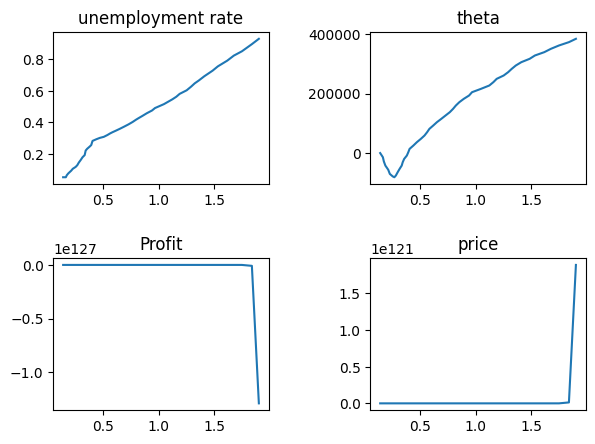